## C2 Trajectory Generation
Generates curvature-continuous trajectory given a set of x,y coordinates and initial and final heading constraints

### Libraries
- Python: scipy.interpolate.CubicSpline
    - Use `bc_type=((1, 0.0), (1, 0.0))` to clamp heading derivatives at the boundaries
- C++: https://www.alglib.net/translator/man/manual.cpython.html#example_spline1d_d_cubic

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import math
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [2]:
def unitvec_from_heading(theta):
    x = np.cos(theta)
    y = np.sin(theta)
    ds = (x**2 + y**2)**0.5
    return (x/ds, y/ds)

In [3]:
def gen_c2_spline(x, y, bc_headings, slen_start, slen_end):
    '''
    Generates a C2 continuous spline using scipy CubicSpline lib
    x: np.array of x-coordinate points
    y: np.array of y-coordinate points
    '''
    
    # define mu, a virtual path variable of length 1 for each spline segment
    assert(len(x) == len(y))
    mu = np.arange(0,len(x), 1.0)

    # build splines
    cs_x = CubicSpline(mu, x, 
                   bc_type=((1, slen_start * np.cos(bc_headings[0])), 
                            (1, slen_end * np.cos(bc_headings[1]))))
    cs_y = CubicSpline(mu, y, 
                   bc_type=((1, slen_start * np.sin(bc_headings[0])), 
                            (1, slen_end * np.sin(bc_headings[1]))))
    return cs_x, cs_y

In [4]:
# Compute the first and last segment path lengths
def calc_spline_length(x_coeffs, y_coeffs, n_ips=20):
    '''
    Returns numerically computed length along cubic spline
    x_coeffs: array of 4 x coefficients
    y_coeffs: array of 4 y coefficients
    '''
    
    t_steps = np.linspace(0.0, 1.0, n_ips)
    spl_coords = np.zeros((n_ips, 2))
    
    spl_coords[:,0] = x_coeffs[0] \
                        + x_coeffs[1] * t_steps \
                        + x_coeffs[2] * np.power(t_steps, 2) \
                        + x_coeffs[3] * np.power(t_steps, 3)
    spl_coords[:,1] = y_coeffs[0] \
                        + y_coeffs[1] * t_steps \
                        + y_coeffs[2] * np.power(t_steps, 2) \
                        + y_coeffs[3] * np.power(t_steps, 3)
        
    slength = np.sum(np.sqrt(np.sum(np.power(np.diff(spl_coords, axis=0), 2), axis=1)))
    return slength

In [5]:
def calc_c2_traj(x, y, bc_headings, eps = 0.005):
    '''
    Iteratively compute spline coefficients until spline length of first and last segment converges
    '''

    # Start with euclidean dist as slen approx for first and last segments
    slen_start = np.sqrt((x[1] - x[0])**2 + (y[1] - y[0])**2)
    slen_end = np.sqrt((x[-1] - x[-2])**2 + (y[-1] - y[-2])**2)
#     print(slen_start, slen_end)

    while True:
        cx, cy = gen_c2_spline(x, y, bc_headings, slen_start, slen_end)
        coeffs_x_start = np.flip(cx.c[:,0])
        coeffs_y_start = np.flip(cy.c[:,0])
        coeffs_x_end = np.flip(cx.c[:,-1])
        coeffs_y_end = np.flip(cy.c[:,-1])

        slen_start_new = calc_spline_length(coeffs_x_start, coeffs_y_start)
        slen_end_new = calc_spline_length(coeffs_x_end, coeffs_y_end)
#         print(slen_start_new, slen_end_new)

        if abs(slen_start_new - slen_start) < eps and abs(slen_end_new - slen_end) < eps:
            break
        else:
            slen_start = slen_start_new
            slen_end = slen_end_new
    return cx, cy

In [6]:
def plot_trajectory(x, y, bch, cx, cy, stepsize=0.1):
    '''
    Plots x-y coords and cx(t)-cy(t) parametric spline
    Plots unit vectors showing the spline headings at boundaries
    Generates c1 and c2 plots showing heading and curvature continuity
    '''
    
    ts = np.arange(0, len(x)-1+stepsize, stepsize)
    ts_plus = np.arange(ts[0]-.2, ts[-1]+.3, stepsize)

    # Heading constraint unit vectors
    hvec_start = unitvec_from_heading(bch[0])
    hvec_end = unitvec_from_heading(bch[-1])

    # Plot trajectory
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_ylim(min(y)-1, max(y)+1)
    ax.set_xlim(min(x)-2, max(x)+2)
    ax.plot(x, y, 'o', label= 'nodes')
    ax.plot(cx(ts_plus), cy(ts_plus), label='spline')
    ax.annotate("", xy=(x[0] + hvec_start[0], y[0] + hvec_start[1]), xytext=(x[0], y[0]), arrowprops=dict(arrowstyle="->", color="red"))
    ax.annotate("", xy=(x[-1] + hvec_end[0], y[-1] + hvec_end[1]), xytext=(x[-1], y[-1]), arrowprops=dict(arrowstyle="->", color="red"))
    ax.set_aspect('equal')
    ax.set_title('C2 trajectory')
    ax.set_xlabel('x(mu)')
    ax.set_ylabel('y(mu)')
    
    # Plot heading and curvature
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].set_title('X(mu)')
    ax[0].plot(ts, cx(ts,1), label='Heading')
    ax[0].plot(ts, cx(ts,2), label='Curvature')
    ax[0].set_xlabel('mu')
    ax[0].legend()
    ax[1].set_title('Y(mu)')
    ax[1].plot(ts, cy(ts,1), label='Heading')
    ax[1].plot(ts, cy(ts,2), label='Curvature')
    ax[1].set_xlabel('mu')
    ax[1].legend()

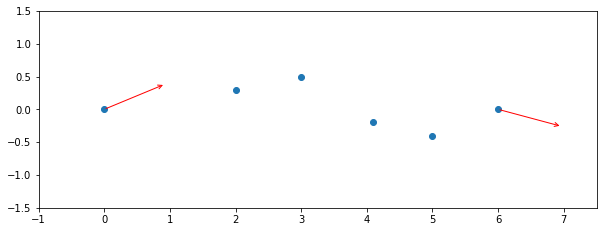

In [7]:
# Build Test Case
# points defined as (x,y,theta)
bc_headings = (np.pi/8, -np.pi/12)
nodes = [(0,0,bc_headings[0]), 
         (2.0, 0.3, None), 
         (3.0, 0.5, None), 
         (4.1, -0.2, None),
         (5.0, -0.4, None), 
         (6.0, 0.0, bc_headings[1])]
x = np.array([i[0] for i in nodes])
y = np.array([i[1] for i in nodes])
bch = np.array([i[2] for i in nodes])
theta = np.array([i[2] for i in nodes])

# Heading constraint unit vectors
hvec_start = unitvec_from_heading(bch[0])
hvec_end = unitvec_from_heading(bch[-1])

# Plot test case
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_ylim(-1.5, 1.5)
ax.set_xlim(-1, 7.5)
ax.scatter(x,y)
ax.annotate("", xy=(x[0] + hvec_start[0], y[0] + hvec_start[1]), xytext=(x[0], y[0]), arrowprops=dict(arrowstyle="->", color="red"))
ax.annotate("", xy=(x[-1] + hvec_end[0], y[-1] + hvec_end[1]), xytext=(x[-1], y[-1]), arrowprops=dict(arrowstyle="->", color="red"))
ax.set_aspect('equal')

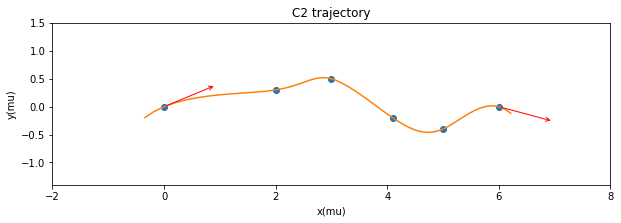

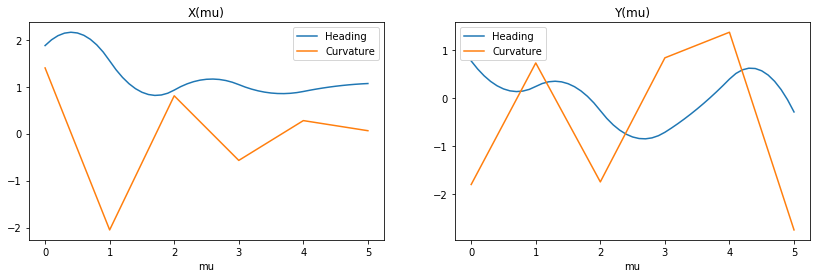

In [8]:
## Test iterative calc trajectory generation
cx, cy = calc_c2_traj(x, y, bc_headings)

## Plot
plot_trajectory(x, y, bch, cx, cy)

In [12]:
t = np.linspace(0,1,50)
cx(t)

array([0.        , 0.03856148, 0.07767637, 0.11731534, 0.15744907,
       0.19804823, 0.23908348, 0.28052551, 0.32234499, 0.36451259,
       0.40699898, 0.44977483, 0.49281083, 0.53607763, 0.57954592,
       0.62318637, 0.66696965, 0.71086643, 0.75484739, 0.7988832 ,
       0.84294453, 0.88700205, 0.93102644, 0.97498838, 1.01885852,
       1.06260756, 1.10620615, 1.14962497, 1.19283471, 1.23580602,
       1.27850958, 1.32091606, 1.36299615, 1.4047205 , 1.44605979,
       1.48698471, 1.52746591, 1.56747407, 1.60697987, 1.64595397,
       1.68436706, 1.7221898 , 1.75939287, 1.79594693, 1.83182267,
       1.86699075, 1.90142186, 1.93508665, 1.96795581, 2.        ])

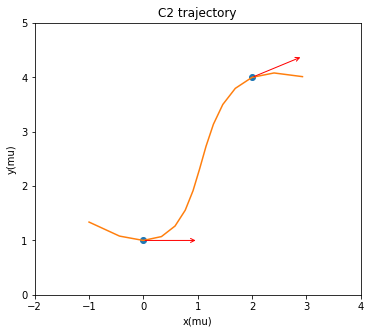

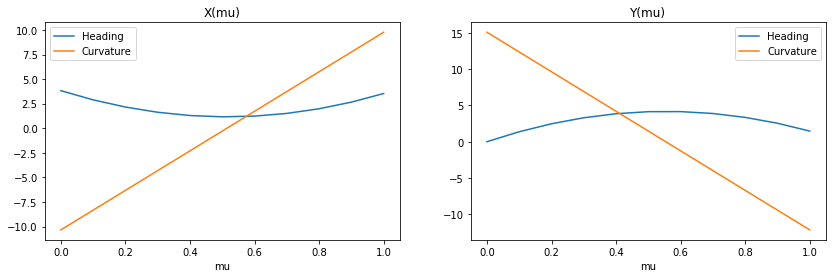

In [9]:
## Test single spline segment case
xr = np.array([0,2])
yr = np.array([1,4])
bcr = np.array([0, np.pi/8])
cxr, cyr = calc_c2_traj(xr, yr, bcr)

plot_trajectory(xr, yr, bcr, cxr, cyr)